In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve

EXPLORACIÓN Y TRANSFORMACIONES DE DIAMONDS_TRAIN

In [44]:
diamonds_train = pd.read_csv("data/diamonds_train.csv")
diamonds_train = diamonds_train.drop(["index_id", "city_id", "city_id.1", "index_id.1", "cut_id", "color_id", "color_id.1", "clarity_id", "cut_id.1", "index_id.2", "clarity_id.1"], axis = 1)

In [45]:
diamonds_test = pd.read_csv("data/diamonds_test.csv")

In [46]:
numeric_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
for col in numeric_cols:
    diamonds_train[col + '_sqrt'] = np.sqrt(diamonds_train[col])
    diamonds_test[col + '_sqrt'] = np.sqrt(diamonds_test[col])

In [47]:
diamonds_train['depth_sin'] = np.sin(diamonds_train['depth'])
diamonds_train['depth_cos'] = np.cos(diamonds_train['depth'])
diamonds_test['depth_sin'] = np.sin(diamonds_test['depth'])
diamonds_test['depth_cos'] = np.cos(diamonds_test['depth'])

In [48]:
diamonds_train['carat_depth_interaction'] = diamonds_train['carat'] * diamonds_train['depth']
diamonds_test['carat_depth_interaction'] = diamonds_test['carat'] * diamonds_test['depth']

In [49]:
diamonds_train['density'] = diamonds_train['carat'] / diamonds_train['x'] * diamonds_train['y'] * diamonds_train['z']
diamonds_test['density'] = diamonds_test['carat'] / diamonds_test['x'] * diamonds_test['y'] * diamonds_test['z']


In [50]:
#Voy a quitar los outliers
columns_outliers = ["carat", "depth", "table", "x", "y", "z"]

for c in columns_outliers:

    Q1 = diamonds_train[c].quantile(0.25)
    Q3 = diamonds_train[c].quantile(0.75)

    IQR = Q3-Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    diamonds_train[c] = diamonds_train[c].clip(lower=limite_inferior, upper=limite_superior)
    

In [51]:
numeric_columns = diamonds_train.select_dtypes(include=['int', 'float']).columns
mean_values = diamonds_train[numeric_columns].mean()
diamonds_train[numeric_columns] = diamonds_train[numeric_columns].replace(0, mean_values)

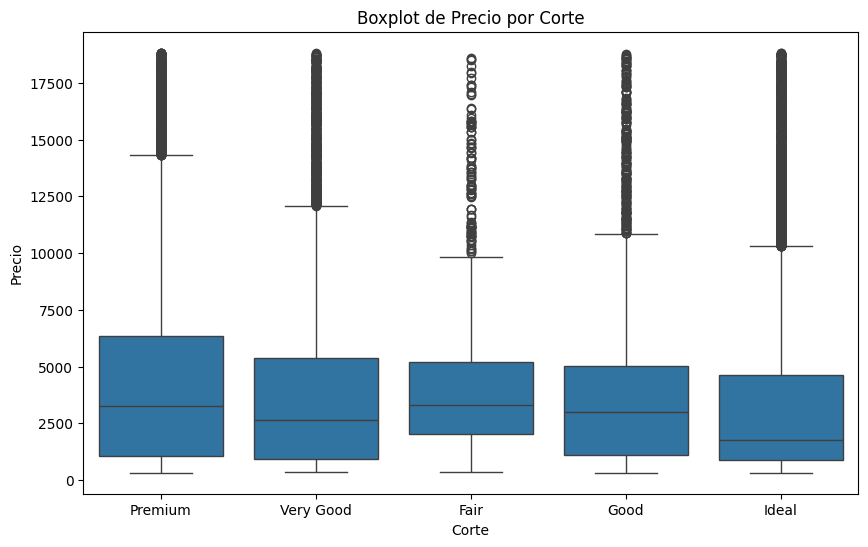

'Curiosamente, el corte de peor calidad (fair) parte siempre\nde un precio más alto.'

In [52]:
#Analizo la relación entre los distintos tipos de corte y el precio

plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='cut', y='price')
plt.title('Boxplot de Precio por Corte')
plt.xlabel('Corte')
plt.ylabel('Precio')
plt.show()

"""Curiosamente, el corte de peor calidad (fair) parte siempre
de un precio más alto."""

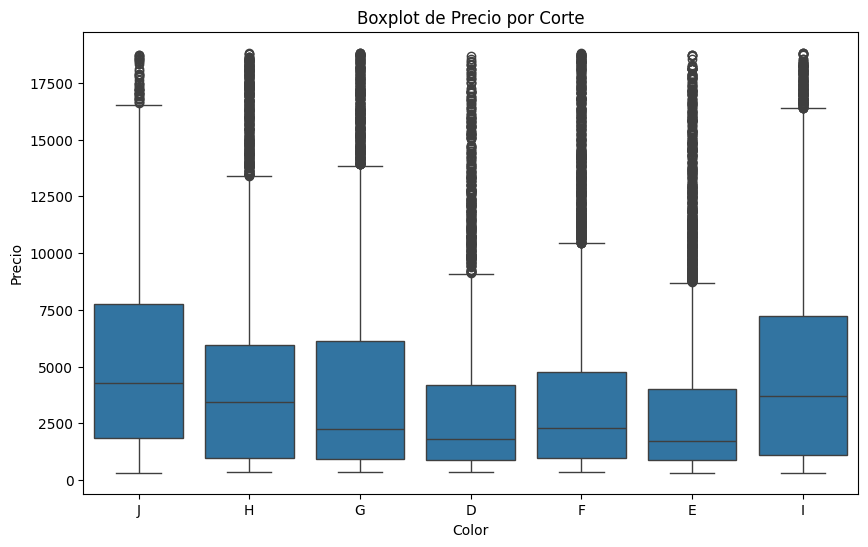

'De nuevo, el peor color (J) es el que parte de un mayor precio \ninicial. Tal vez haya que modificar las labels del encoding. El D, \nque en teoría es el mejor color, tiene un rango de precio mucho más\npequeño'

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='color', y='price')
plt.title('Boxplot de Precio por Corte')
plt.xlabel('Color')
plt.ylabel('Precio')
plt.show()

"""De nuevo, el peor color (J) es el que parte de un mayor precio 
inicial. Tal vez haya que modificar las labels del encoding. El D, 
que en teoría es el mejor color, tiene un rango de precio mucho más
pequeño"""

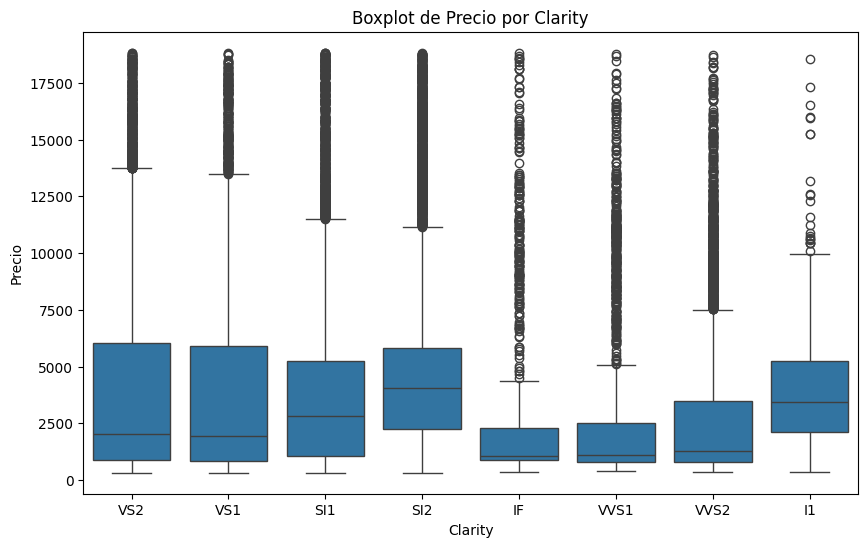

'De nuevo, los dos peores (I1, SI1) tienen precios más elevados.'

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='clarity', y='price')
plt.title('Boxplot de Precio por Clarity')
plt.xlabel('Clarity')
plt.ylabel('Precio')
plt.show()
"""De nuevo, los dos peores (I1, SI1) tienen precios más elevados."""

In [55]:
"""Voy a ver cuáles tienen mayor relación con un precio elevado
dentro de cada categoría para modificar el label encoding y que
tenga sentido."""

'Voy a ver cuáles tienen mayor relación con un precio elevado\ndentro de cada categoría para modificar el label encoding y que\ntenga sentido.'

In [56]:
diamonds_train["cut_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["cut"] == "Fair":
        diamonds_train.at[i, "cut_encoded"] = 1.0
    elif r["cut"] == "Good":
        diamonds_train.at[i, "cut_encoded"] = 0.7937
    elif r["cut"] == "Very Good":
        diamonds_train.at[i, "cut_encoded"] = 0.565
    elif r["cut"] == "Premium":
        diamonds_train.at[i, "cut_encoded"] = 0.9604
    elif r["cut"] == "Ideal":
        diamonds_train.at[i, "cut_encoded"] = 0
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,...,depth_sqrt,table_sqrt,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,...,7.899367,7.615773,2.613427,2.605763,2.061553,-0.418554,0.908192,75.504,5.112383,0.9604
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,...,7.937254,7.549834,2.085665,2.092845,1.658312,0.167356,0.985897,20.160,0.886069,0.5650
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,...,8.093207,7.416198,2.370654,2.351595,1.910497,0.455956,-0.890002,46.505,2.549999,1.0000
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,...,7.987490,7.483315,2.163331,2.172556,1.732051,0.823837,0.566827,26.158,1.240513,0.7937
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,...,7.778175,7.681146,2.559297,2.551470,1.987461,-0.724108,-0.689687,61.710,4.004395,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,...,7.918333,7.549834,2.664583,2.653300,2.104757,-0.131471,0.991320,84.018,5.886035,0.0000
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,...,7.556454,7.745967,2.882707,2.872281,2.174856,0.523823,0.851827,115.342,9.485614,0.7937
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,...,7.918333,7.483315,2.523886,2.533772,2.002498,-0.131471,0.991320,63.327,4.081890,0.0000
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,...,7.867655,7.368853,2.109502,2.114237,1.661325,-0.802726,0.596347,20.427,0.914893,0.0000


In [57]:
diamonds_train["clarity_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["clarity"] == "I1":
        diamonds_train.at[i, "clarity_encoded"] = 0.7888
    elif r["clarity"] == "SI2":
        diamonds_train.at[i, "clarity_encoded"] = 1.0
    elif r["clarity"] == "SI1":
        diamonds_train.at[i, "clarity_encoded"] = 0.5826
    elif r["clarity"] == "VS2":
        diamonds_train.at[i, "clarity_encoded"] = 0.3198
    elif r["clarity"] == "VS1":
        diamonds_train.at[i, "clarity_encoded"] = 0.2933
    elif r["clarity"] == "VVS2":
        diamonds_train.at[i, "clarity_encoded"] = 0.0698
    elif r["clarity"] == "VVS1":
        diamonds_train.at[i, "clarity_encoded"] = 0.0057
    elif r["clarity"] == "IF":
        diamonds_train.at[i, "clarity_encoded"] = 0
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,...,table_sqrt,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded,clarity_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,...,7.615773,2.613427,2.605763,2.061553,-0.418554,0.908192,75.504,5.112383,0.9604,0.3198
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,...,7.549834,2.085665,2.092845,1.658312,0.167356,0.985897,20.160,0.886069,0.5650,0.3198
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,...,7.416198,2.370654,2.351595,1.910497,0.455956,-0.890002,46.505,2.549999,1.0000,0.2933
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,...,7.483315,2.163331,2.172556,1.732051,0.823837,0.566827,26.158,1.240513,0.7937,0.5826
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,...,7.681146,2.559297,2.551470,1.987461,-0.724108,-0.689687,61.710,4.004395,0.0000,0.5826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,...,7.549834,2.664583,2.653300,2.104757,-0.131471,0.991320,84.018,5.886035,0.0000,0.2933
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,...,7.745967,2.882707,2.872281,2.174856,0.523823,0.851827,115.342,9.485614,0.7937,1.0000
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,...,7.483315,2.523886,2.533772,2.002498,-0.131471,0.991320,63.327,4.081890,0.0000,0.5826
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,...,7.368853,2.109502,2.114237,1.661325,-0.802726,0.596347,20.427,0.914893,0.0000,0.2933


In [58]:
diamonds_train["color_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["color"] == "J":
        diamonds_train.at[i, "color_encoded"] = 1
    elif r["color"] == "I":
        diamonds_train.at[i, "color_encoded"] = 0.7784
    elif r["color"] == "H":
        diamonds_train.at[i, "color_encoded"] = 0.6759
    elif r["color"] == "G":
        diamonds_train.at[i, "color_encoded"] = 0.2078
    elif r["color"] == "F":
        diamonds_train.at[i, "color_encoded"] =  0.2277
    elif r["color"] == "E":
        diamonds_train.at[i, "color_encoded"] = 0
    elif r["color"] == "D":
        diamonds_train.at[i, "color_encoded"] = 0.0335
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,...,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded,clarity_encoded,color_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,...,2.613427,2.605763,2.061553,-0.418554,0.908192,75.504,5.112383,0.9604,0.3198,1.0000
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,...,2.085665,2.092845,1.658312,0.167356,0.985897,20.160,0.886069,0.5650,0.3198,0.6759
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,...,2.370654,2.351595,1.910497,0.455956,-0.890002,46.505,2.549999,1.0000,0.2933,0.2078
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,...,2.163331,2.172556,1.732051,0.823837,0.566827,26.158,1.240513,0.7937,0.5826,0.0335
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,...,2.559297,2.551470,1.987461,-0.724108,-0.689687,61.710,4.004395,0.0000,0.5826,0.2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,...,2.664583,2.653300,2.104757,-0.131471,0.991320,84.018,5.886035,0.0000,0.2933,0.2078
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,...,2.882707,2.872281,2.174856,0.523823,0.851827,115.342,9.485614,0.7937,1.0000,0.2277
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,...,2.523886,2.533772,2.002498,-0.131471,0.991320,63.327,4.081890,0.0000,0.5826,0.6759
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,...,2.109502,2.114237,1.661325,-0.802726,0.596347,20.427,0.914893,0.0000,0.2933,1.0000


In [59]:
diamonds_train = diamonds_train.drop(["city", "color", "cut","clarity","x", "y", "z"], axis=1)

EXPLORACIÓN Y TRANSFORMACIONES DE DIAMONDS_TEST

In [60]:
for c in columns_outliers:

    Q1 = diamonds_test[c].quantile(0.25)
    Q3 = diamonds_test[c].quantile(0.75)

    IQR = Q3-Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    diamonds_test[c] = diamonds_test[c].clip(lower=limite_inferior, upper=limite_superior)

In [61]:
numeric_columns = diamonds_test.select_dtypes(include=['int', 'float']).columns

mean_values = diamonds_test[numeric_columns].mean()

diamonds_test[numeric_columns] = diamonds_test[numeric_columns].replace(0, mean_values)

In [62]:
diamonds_test["cut_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["cut"] == "Fair":
        diamonds_test.at[i, "cut_encoded"] = 1.0
    elif r["cut"] == "Good":
        diamonds_test.at[i, "cut_encoded"] = 0.7937
    elif r["cut"] == "Very Good":
        diamonds_test.at[i, "cut_encoded"] = 0.565
    elif r["cut"] == "Premium":
        diamonds_test.at[i, "cut_encoded"] = 0.9604
    elif r["cut"] == "Ideal":
        diamonds_test.at[i, "cut_encoded"] = 0
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,...,depth_sqrt,table_sqrt,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,...,7.918333,7.745967,2.412468,2.426932,1.915724,-0.131471,0.991320,49.533,2.934171,0.5650
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,...,7.810250,7.549834,2.609598,2.624881,2.044505,-0.966118,-0.258102,73.200,5.074925,0.0000
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,...,7.886698,7.810250,2.716616,2.705550,2.137756,-0.590641,0.806934,97.654,7.116567,0.9604
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,...,7.987490,7.348469,2.467793,2.475884,1.974842,0.823837,0.566827,57.420,3.533054,0.5650
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,...,7.930952,7.615773,2.247221,2.256103,1.786057,0.068094,0.997679,31.450,1.607634,0.5650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,...,7.867655,7.483315,2.313007,2.306513,1.816590,-0.802726,0.596347,35.283,1.870452,0.0000
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,...,7.886698,7.416198,2.389561,2.393742,1.886796,-0.590641,0.806934,44.162,2.536453,0.0000
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,...,7.848567,7.416198,2.397916,2.389561,1.878829,-0.943107,0.332491,43.120,2.453810,0.0000
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,...,7.668116,7.549834,2.418677,2.426932,1.857418,0.777236,-0.629210,41.160,2.431513,0.5650


In [63]:
diamonds_test["clarity_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["clarity"] == "I1":
        diamonds_test.at[i, "clarity_encoded"] = 0.7888
    elif r["clarity"] == "SI2":
        diamonds_test.at[i, "clarity_encoded"] = 1.0
    elif r["clarity"] == "SI1":
        diamonds_test.at[i, "clarity_encoded"] = 0.5826
    elif r["clarity"] == "VS2":
        diamonds_test.at[i, "clarity_encoded"] = 0.3198
    elif r["clarity"] == "VS1":
        diamonds_test.at[i, "clarity_encoded"] = 0.2933
    elif r["clarity"] == "VVS2":
        diamonds_test.at[i, "clarity_encoded"] = 0.0698
    elif r["clarity"] == "VVS1":
        diamonds_test.at[i, "clarity_encoded"] = 0.0057
    elif r["clarity"] == "IF":
        diamonds_test.at[i, "clarity_encoded"] = 0
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,...,table_sqrt,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded,clarity_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,...,7.745967,2.412468,2.426932,1.915724,-0.131471,0.991320,49.533,2.934171,0.5650,0.5826
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,...,7.549834,2.609598,2.624881,2.044505,-0.966118,-0.258102,73.200,5.074925,0.0000,0.2933
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,...,7.810250,2.716616,2.705550,2.137756,-0.590641,0.806934,97.654,7.116567,0.9604,0.5826
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,...,7.348469,2.467793,2.475884,1.974842,0.823837,0.566827,57.420,3.533054,0.5650,0.5826
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,...,7.615773,2.247221,2.256103,1.786057,0.068094,0.997679,31.450,1.607634,0.5650,0.2933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,...,7.483315,2.313007,2.306513,1.816590,-0.802726,0.596347,35.283,1.870452,0.0000,0.5826
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,...,7.416198,2.389561,2.393742,1.886796,-0.590641,0.806934,44.162,2.536453,0.0000,0.3198
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,...,7.416198,2.397916,2.389561,1.878829,-0.943107,0.332491,43.120,2.453810,0.0000,0.2933
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,...,7.549834,2.418677,2.426932,1.857418,0.777236,-0.629210,41.160,2.431513,0.5650,1.0000


In [64]:
diamonds_test["color_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["color"] == "J":
        diamonds_test.at[i, "color_encoded"] = 1.0
    elif r["color"] == "I":
        diamonds_test.at[i, "color_encoded"] = 0.7784
    elif r["color"] == "H":
        diamonds_test.at[i, "color_encoded"] = 0.6759
    elif r["color"] == "G":
        diamonds_test.at[i, "color_encoded"] = 0.2078
    elif r["color"] == "F":
        diamonds_test.at[i, "color_encoded"] = 0.2277
    elif r["color"] == "E":
        diamonds_test.at[i, "color_encoded"] = 0
    elif r["color"] == "D":
        diamonds_test.at[i, "color_encoded"] = 0.0335
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,...,x_sqrt,y_sqrt,z_sqrt,depth_sin,depth_cos,carat_depth_interaction,density,cut_encoded,clarity_encoded,color_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,...,2.412468,2.426932,1.915724,-0.131471,0.991320,49.533,2.934171,0.5650,0.5826,0.2277
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,...,2.609598,2.624881,2.044505,-0.966118,-0.258102,73.200,5.074925,0.0000,0.2933,1.0000
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,...,2.716616,2.705550,2.137756,-0.590641,0.806934,97.654,7.116567,0.9604,0.5826,0.6759
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,...,2.467793,2.475884,1.974842,0.823837,0.566827,57.420,3.533054,0.5650,0.5826,0.2277
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,...,2.247221,2.256103,1.786057,0.068094,0.997679,31.450,1.607634,0.5650,0.2933,0.2277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,...,2.313007,2.306513,1.816590,-0.802726,0.596347,35.283,1.870452,0.0000,0.5826,0.0000
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,...,2.389561,2.393742,1.886796,-0.590641,0.806934,44.162,2.536453,0.0000,0.3198,0.7784
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,...,2.397916,2.389561,1.878829,-0.943107,0.332491,43.120,2.453810,0.0000,0.2933,0.2277
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,...,2.418677,2.426932,1.857418,0.777236,-0.629210,41.160,2.431513,0.5650,1.0000,0.2277


In [65]:
diamonds_test = diamonds_test.drop(["city", "color", "cut","clarity", "id", "x", "y", "z"], axis=1)

In [69]:
diamonds_train = diamonds_train.drop(["carat", "depth", "table"], axis=1)
diamonds_test = diamonds_test.drop(["carat", "depth", "table"], axis=1)

In [73]:
diamonds_train = diamonds_train.drop(["carat_sqrt"], axis=1)
diamonds_test = diamonds_test.drop(["carat_sqrt"], axis=1)

In [76]:
diamonds_train = diamonds_train.drop(["z_sqrt"], axis=1)
diamonds_test = diamonds_test.drop(["z_sqrt"], axis=1)

In [74]:
diamonds_train = diamonds_train.drop(["x_sqrt"], axis=1)
diamonds_test = diamonds_test.drop(["x_sqrt"], axis=1)

KeyError: "['x_sqrt'] not found in axis"

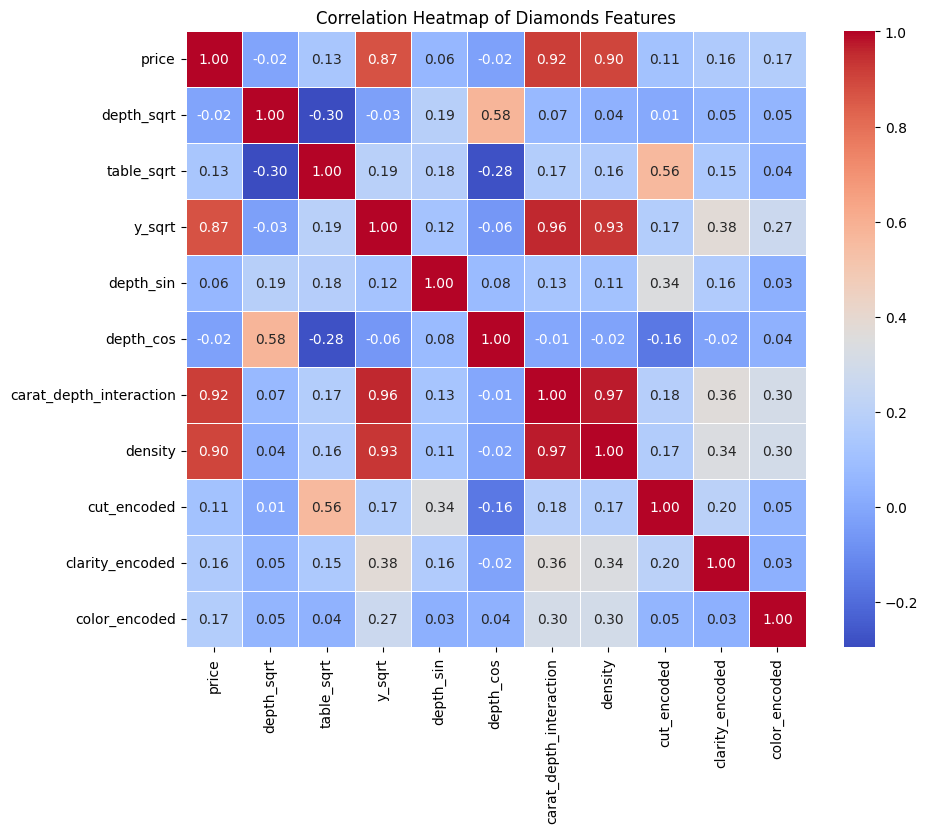

In [77]:
plt.figure(figsize=(10, 8))
sns.heatmap(diamonds_train.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Diamonds Features')
plt.show()

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

In [80]:
X = diamonds_train.drop(columns=['price'])
y = diamonds_train["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
regressor = XGBRegressor()

param_grid = {
    'learning_rate': [0.125, 0.13, 0.132],
    'n_estimators': [355, 360, 362],
    'max_depth': [5]
}

random_search = GridSearchCV(regressor, 
                                   param_grid=param_grid,  
                                   cv=5, 
                                   verbose=3, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=-1)

random_search.fit(X_train, y_train)

y_pred = random_search.best_estimator_.predict(X_test)

# Get the best parameters and the best score

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best parameters found: ", best_params)
print("Best score found: ", best_score)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found:  {'learning_rate': 0.125, 'max_depth': 5, 'n_estimators': 360}
Best score found:  -555.9501469313847


In [82]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.125, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [83]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

540.5188730666546

In [37]:
y_prediction = best_model.predict(diamonds_test)
y_prediction

array([2869.95  , 5621.9585, 9353.735 , ..., 3211.1118, 2053.3992,
        837.4   ], dtype=float32)

In [32]:
solution = []
for i, value in enumerate(y_prediction):
    solution.append((i,value))

In [38]:
submission_file = pd.DataFrame(solution)

In [39]:
submission_file

,0,1
0,0,2869.949951
1,1,5621.958496
2,2,9353.735352
3,3,3968.977051
4,4,1632.334717
...,...,...
13480,13480,1751.517578
13481,13481,2324.520264
13482,13482,3211.111816
13483,13483,2053.399170


In [40]:
submission_file.columns = ["id", "price"]

In [41]:
submission_file.reset_index(drop=True)

,id,price
0,0,2869.949951
1,1,5621.958496
2,2,9353.735352
3,3,3968.977051
4,4,1632.334717
...,...,...
13480,13480,1751.517578
13481,13481,2324.520264
13482,13482,3211.111816
13483,13483,2053.399170


In [42]:
submission_file.to_csv("024.csv", index = False)

[CV 2/5] END learning_rate=0.125, max_depth=5, n_estimators=355;, score=-555.795 total time=   3.0s
[CV 1/5] END learning_rate=0.125, max_depth=5, n_estimators=360;, score=-550.496 total time=   2.7s
[CV 5/5] END learning_rate=0.125, max_depth=5, n_estimators=360;, score=-520.967 total time=   3.0s
[CV 4/5] END learning_rate=0.125, max_depth=5, n_estimators=362;, score=-531.375 total time=   2.8s
[CV 3/5] END learning_rate=0.13, max_depth=5, n_estimators=355;, score=-553.688 total time=   2.9s
[CV 1/5] END learning_rate=0.13, max_depth=5, n_estimators=360;, score=-554.018 total time=   3.4s
[CV 1/5] END learning_rate=0.13, max_depth=5, n_estimators=362;, score=-554.179 total time=   2.9s
[CV 5/5] END learning_rate=0.13, max_depth=5, n_estimators=362;, score=-522.940 total time=   2.7s
[CV 4/5] END learning_rate=0.132, max_depth=5, n_estimators=355;, score=-531.321 total time=   3.1s
[CV 3/5] END learning_rate=0.132, max_depth=5, n_estimators=360;, score=-547.767 total time=   2.6s
[CV 